# P-Net Example Notebook: SKCM tumor purity prediction

Imports:

In [8]:
from pnet import pnet_loader, Pnet
from util import util, sankey_diag

import torch
import seaborn as sns
import pandas as pd
import numpy as np
import random
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import os
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Input

The input in this case is test data provided in the repository. Since the original TCGA SKCM dataset is not available in the data directory, we'll use the test datasets which include RNA expression and copy number amplification data. 

The data is then put into a dictionary shape required for pnet, this is especially useful when using multiple data modalities.

In [9]:
# Use test data from the repository
import pandas as pd

datapath = '../data/test_data/'
rna = pd.read_csv(datapath + 'rna.csv', index_col=0)
cna = pd.read_csv(datapath + 'cna.csv', index_col=0)
genetic_data = {'rna': rna, 'cna': cna}  # Bring input into dictionary shape

### Load Target

In this example notebook we use tumor purity as a target. The test data includes purity values in the additional data file.

In [10]:
# Load purity data from the test dataset
add_data = pd.read_csv(datapath + 'add.csv', index_col=0)
# The test data has 'Purity' column with values
purity = pd.DataFrame(add_data['Purity'])

We have the tumor purity as a continuous number in [0,1] and can use this for a regression task

In [11]:
purity.head()

,Purity
sample_id,
Sample159,0.78
Sample146,0.89
Sample117,0.33
Sample10,0.83
Sample61,0.42


## Run pnet

We limit the number of genes used for prediction to some subset of informative cancer genes

In [12]:
# Use the gene subset from test data (pickle file)
import pickle
with open('../data/test_data/gene_sublist.txt', 'rb') as f:
    canc_genes = pickle.load(f)
print(f"Using {len(canc_genes)} genes from test data")
canc_genes[:5]

Using 500 genes from test data


['PPFIBP1', 'NF1', 'CCDC6', 'PRDM2', 'RNF43']

The Pnet model can then be trained by simply calling Pnet.run() with the input dictionairy and the target dataframe. Additionally, here we use the cancer gene list. Many more options are available to specific training.

In [13]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         purity,
                                                                         gene_set=canc_genes)

Task defined: REG 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 20 overlapping indicies
Initializing Train Dataset
Found 500 overlapping genes
generated input DataFrame of size (16, 1000)
Initializing Test Dataset
Found 500 overlapping genes
generated input DataFrame of size (4, 1000)
Found 500 overlapping genes
Loss function used: MSELoss()
Hit early stopping criteria


The Pnet model automatically generates a train and test dataset from the input. Here we can use these for illustration of the results on the test dataset:

In [14]:
x_train = train_dataset.x
additional_train = train_dataset.additional
y_train = train_dataset.y
x_test = test_dataset.x
additional_test = test_dataset.additional
y_test = test_dataset.y

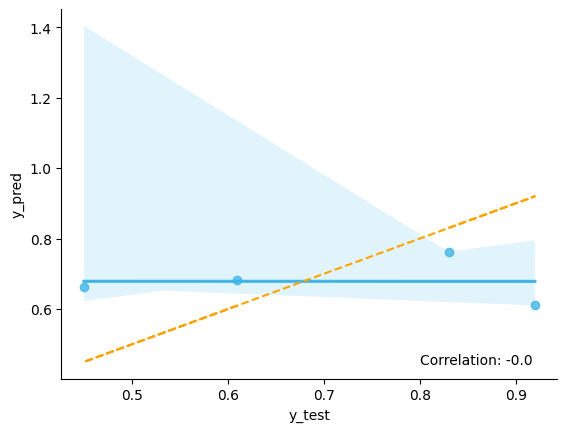

In [15]:
model.to('cpu')

y_pred = model.predict(test_dataset.x, test_dataset.additional).detach()

df = pd.DataFrame(index=test_dataset.input_df.index)
df['y_test'] = test_dataset.y
df['y_pred'] = y_pred

sns.regplot(data=df, x='y_test', y='y_pred', color='#41B6E6')
correlation_coefficient = round(df['y_test'].corr(df['y_pred']), 2)
plt.text(0.95, 0.05, f'Correlation: {correlation_coefficient}', ha='right', va='center', transform=plt.gca().transAxes)
plt.plot(y_test, y_test, color='#FFA300', linestyle='--', label='Diagonal Line')
sns.despine()
plt.show()

For a quick look at the importance scores we can run model.interpret with the test dataset. We recommend however, to use multiple folds of cross validation before inspecting feature and pathway importances, since individual runs can drastically differ and only stable features across runs can be considered important.

In [16]:
gene_feature_importances, additional_feature_importances, gene_importances, layer_importance_scores = model.interpret(test_dataset)
layer_list = [gene_feature_importances, additional_feature_importances, gene_importances] + layer_importance_scores
layer_list_names = ['gene_feature', 'additional_feature', 'gene'] + [f'layer_{i}' for i in range(5)]
layer_list_dict = dict(zip(layer_list_names, layer_list))

To visualize feature importances, one can generate a Sankey Diagram across all layers of the model:

In [17]:
savepath = '../results/skcm_purity_sankey.html'  # Save to results directory
sk = sankey_diag.SankeyDiag(layer_list_dict, runs=1)
fig = sk.get_sankey_diag(savepath)

TypeError: agg function failed [how->mean,dtype->object]

### External Validation

#### Data Loading

Since we're using test data, we'll skip the external validation on the Liu 2019 cohort. In a real scenario with full TCGA data, this would demonstrate the model's generalizability to independent datasets.

In [ ]:
# External validation code - commented out for test data demo
# To run external validation, you would need to download the Liu 2019 cohort data
# from https://doi.org/10.1038/s41591-019-0654-5

print("External validation section skipped - using test data only")

#### Predict Validation Samples

In [ ]:
# Skip prediction on validation samples
pass

#### Plot Validation Samples

In [ ]:
# Skip validation plotting
print("Validation plotting skipped - no external validation data available")

We can see that even in a independent dataset Pnet is generally predicting purity well. It is overestimating the purity in the validation set slightly, especially for lower purity samples. Maybe the performance could be improved by using a customary loss function for the problem at hand.

## Use custom loss function

We define a weighted MSE loss that penalizes bad predictions in extreme samples more. Bad predictions in a sample with very high or very low purity would be more influencial to the model than in average purity samples.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, input, target):
        # Calculate the absolute distance of the true values from 0.5
        distance_from_center = torch.abs(target - 0.5)
        # Scale weights as needed; further from 0.5 gets higher weight
        # This example linearly increases the weight as the distance from 0.5 increases
        weights = 1 + distance_from_center 
        # Calculate weighted MSE
        se = (input - target) ** 2
        weighted_se = weights * se
        loss = weighted_se.mean()
        return loss


The custom loss function easily integrates into the model training.

In [ ]:
model, train_scores, test_scores, train_dataset, test_dataset = Pnet.run(genetic_data,
                                                                         purity,
                                                                         gene_set=canc_genes,
                                                                         loss_fn = WeightedMSELoss())

Task defined: REG 
 if this is not the intended task please specify task
Given 2 Input modalities
Found 357 overlapping indicies
Initializing Train Dataset
Found 626 overlapping genes
generated input DataFrame of size (286, 1252)
Initializing Test Dataset
Found 626 overlapping genes
generated input DataFrame of size (71, 1252)
Found 626 overlapping genes
We are sending to cuda
Hit early stopping criteria


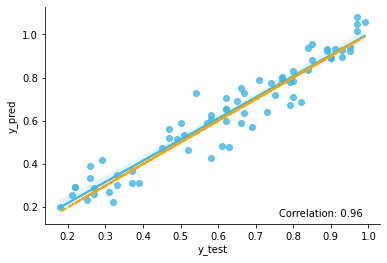

In [ ]:
model.to('cpu')

y_pred = model.predict(x_test, additional_test).detach()

df = pd.DataFrame(index=test_dataset.input_df.index)
df['y_test'] = y_test
df['y_pred'] = y_pred

sns.regplot(data=df, x='y_test', y='y_pred', color='#41B6E6')
correlation_coefficient = round(df['y_test'].corr(df['y_pred']), 2)
plt.text(0.95, 0.05, f'Correlation: {correlation_coefficient}', ha='right', va='center', transform=plt.gca().transAxes)
plt.plot(y_test, y_test, color='#FFA300', linestyle='--', label='Diagonal Line')
sns.despine()
plt.show()

Performance in the test dataset is already much higher. Especially in extreme samples.

In [ ]:
# Skip external validation with custom loss
print("External validation with custom loss function skipped - no external data available")